## Building model for used cars price prediction
### Action plan:
1. Loas data 
2. Freature engineering - generate new features
3. Featire transform
4. Make pipline
5. Fit and tuning models
6. Interpret result

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import statsmodels.api as sm

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [3]:
sorted(glob('../../data/1_automarket_exploration/source_data/clean_data_offer_used*'))

['../../data/1_automarket_exploration/source_data/clean_data_offer_used 2020-03-02 20:04.csv',
 '../../data/1_automarket_exploration/source_data/clean_data_offer_used 2020-03-03 17:14.csv',
 '../../data/1_automarket_exploration/source_data/clean_data_offer_used 2020-09-04 13:17.csv',
 '../../data/1_automarket_exploration/source_data/clean_data_offer_used 2020-10-19 19:10.csv',
 '../../data/1_automarket_exploration/source_data/clean_data_offer_used 2020-10-19 19:12.csv']

### 1. Load data

In [4]:
# load data clean_data_offer_used 2020-03-03 17:09.csv
offer_data = pd.read_csv('../../data/1_automarket_exploration/source_data/clean_data_offer_used 2020-10-19 19:12.csv', index_col=0)

In [5]:
offer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244659 entries, 0 to 246323
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   producer               244659 non-null  object 
 1   model_name             244659 non-null  object 
 2   price                  244659 non-null  int64  
 3   age                    244659 non-null  int64  
 4   kmage                  244659 non-null  int64  
 5   region                 244659 non-null  object 
 6   engine_volume          244659 non-null  float64
 7   engine_power           244659 non-null  float64
 8   fuel                   244659 non-null  object 
 9   gear                   244659 non-null  object 
 10  case                   244659 non-null  object 
 11  drive_type             244659 non-null  object 
 12  color                  244659 non-null  object 
 13  offer_count_by_region  244659 non-null  int64  
 14  lat                    244659 non-nu

### Short EDA

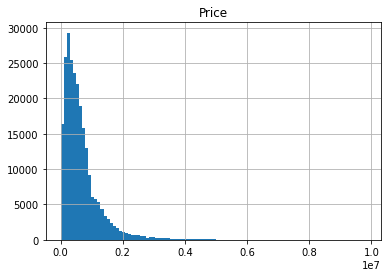

In [6]:
offer_data['price'].hist(bins=100)
plt.title('Price');

Logarithm price


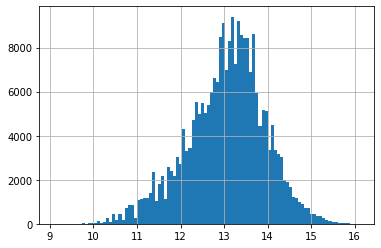

In [7]:
np.log(offer_data['price']).hist(bins=100)
print('Logarithm price')

In [7]:
category_columns = [col_name  for col_name in offer_data.columns if offer_data[col_name].dtype == 'object']
print(category_columns)
numeric_columns = [col_name  for col_name in offer_data.columns if offer_data[col_name].dtype != 'object']
print(numeric_columns)

['producer', 'model_name', 'region', 'fuel', 'gear', 'case', 'drive_type', 'color', 'macro_name', 'origin_of_producer', 'platform']
['price', 'age', 'kmage', 'engine_volume', 'engine_power', 'offer_count_by_region', 'lat', 'lng', 'specific_power']


In [10]:
offer_data[category_columns].describe()

,producer,model_name,region,fuel,gear,case,drive_type,color,macro_name,origin_of_producer,platform
count,244659,244659,244659,244659,244659,244659,244659,244659,244659,244659,244659
unique,12,1513,4287,4,4,19,3,16,289,6,128
top,LADA,LADA (ВАЗ) 2115,Москва,Бензин,механика,седан,передний,чёрный,Москва,Japan,Volkswagen Passat
freq,40058,3694,36251,213769,114382,102459,149909,58264,37013,57313,4426


In [11]:
offer_data[numeric_columns].describe()

,price,age,kmage,engine_volume,engine_power,offer_count_by_region,lat,lng,specific_power
count,2.446590e+05,244659.000000,244659.000000,244659.000000,244659.000000,244659.000000,244659.000000,244659.000000,244659.000000
mean,6.681092e+05,2009.941085,139531.335406,2.014756,140.537458,7761.495428,54.211054,46.455883,69.170906
std,6.367128e+05,5.408746,85909.282204,0.722566,60.893459,12511.295958,4.794097,16.543596,13.736938
min,9.000000e+03,1990.000000,1.000000,0.800000,45.000000,1.000000,13.062550,-90.070381,27.692308
25%,2.690000e+05,2007.000000,80000.000000,1.600000,98.000000,313.000000,52.591257,37.622504,61.250000
50%,5.000000e+05,2011.000000,128500.000000,1.700000,124.000000,1589.000000,55.753215,39.736375,69.285714
75%,8.390000e+05,2014.000000,183800.000000,2.000000,167.000000,6570.000000,56.414927,50.101783,76.000000
max,9.800000e+06,2019.000000,999999.000000,6.600000,610.000000,36418.000000,75.936382,162.582544,140.000000


In [12]:
offer_data['macro_name'].unique()

array(['Московская область', 'Москва', 'Ростов-на-Дону', 'Пермь',
       'Санкт-Петербург', 'Нижний Новгород', 'Ставропольский край',
       'Тула', 'Брянск', 'Владимирская область', 'Республика Татарстан',
       'Свердловская область', 'Республика Башкортостан', 'Краснодар',
       'Рязань', 'Саратов', 'Ставрополь', 'Тамбов', 'Челябинская область',
       'Красноярск', 'Самарская область', 'Иваново', 'Республика Карелия',
       'Воронеж', 'Челябинск', 'Ростовская область', 'Псков', 'Мурманск',
       'Тюмень', 'Калуга', 'Псковская область', 'Пенза',
       'Краснодарский край', 'Белгородская область',
       'Калининградская область', 'город Луга', 'Омск', 'Республика Крым',
       'Иркутск', 'Смоленская область', 'Оренбург', 'Архангельск',
       'Самара', 'Вологодская область', 'Архангельская область',
       'Республика Дагестан', 'Красноярский край', 'Белгород',
       'Ярославль', 'Республика Марий Эл', 'Волгоградская область',
       'Курган', 'Чувашская Республика', 'Новосиби

### 2. Feature engineering
We have total car count in region, but we can add count of current model or brand that could dtermine servise aviability in each region or customer preference.


In [8]:
# количество авто данной модели всего
offer_count_model = offer_data['model_name'].value_counts().to_frame().reset_index()
offer_count_model.columns = ['model_name', 'offer_count_by_model']

In [9]:
# количество авто данной модели в регионе
offer_count_model_macro_region = offer_data.groupby(['model_name', 'macro_name'], as_index=False)\
                                           .count()[['model_name', 'macro_name', 'producer']]
offer_count_model_macro_region.columns = ['model_name', 'macro_name', 'offer_count_by_model_macro_region']

In [10]:
# количество авто данной производителя в регионе
offer_count_prod_macro_region = offer_data.groupby(['producer', 'macro_name'], as_index=False)\
                                           .count()[['producer', 'macro_name', 'model_name']]
offer_count_prod_macro_region.columns = ['producer', 'macro_name', 'offer_count_by_prod_macro_region']

In [8]:
offer_data.shape

(244659, 20)

In [11]:
offer_data = pd.merge(offer_data, offer_count_model, on='model_name')
offer_data = pd.merge(offer_data, offer_count_model_macro_region, on=['model_name', 'macro_name'])
offer_data = pd.merge(offer_data, offer_count_prod_macro_region, on=['producer', 'macro_name'])

In [10]:
offer_data.head(1).T

,0
producer,BMW
model_name,BMW 1 серия II (F20/F21) 116i
price,850000
age,2012
kmage,81000
region,Одинцово
engine_volume,1.6
engine_power,136
fuel,Бензин
gear,автомат


## TODO: Add some grouped features

### 2.1 Feature transform

In [26]:
y_col = 'price'

X_data = offer_data.drop(columns=[y_col])
y_data = offer_data[y_col]

enc = OrdinalEncoder()
X_data[category_columns] = enc.fit_transform(X_data[category_columns])

### 3.1 Train test split

In [30]:
%%time

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size=0.4, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, 
                                                    test_size=0.5, random_state=42)

CPU times: user 47.4 ms, sys: 0 ns, total: 47.4 ms
Wall time: 46.2 ms


In [31]:
print(X_data.shape)
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(244659, 22)
(146795, 22)
(48932, 22)
(48932, 22)


## 3. Model fitting
### 3.1. Baseline constant model

In [32]:
y_pred_const = pd.Series(y_train.median(), index=y_test.index)

In [33]:
print("Mean Absolute Error : {:.2f}".format(mean_absolute_error(y_test, y_pred_const)))

Mean Absolute Error : 394129.23


### Resume:
Constant model error on 394k in price of car

In [34]:
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1).iloc[:25]
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')
    plt.show()
    
    
def plot_prediction(y_pred, y_true):
    plt.figure(figsize=(12,8))
    plt.scatter(y_pred, y_true, alpha=0.6)
    plt.xlabel('Predictions')
    plt.ylabel('True values')
    plt.grid()
    plt.show()

## TODO add cross_val_score and hyperparametrs tuning

### 3.2 Linear Models

In [35]:
%%time
lasso = Lasso()
lasso.fit(X_train, y_train)

CPU times: user 23.2 s, sys: 7.6 s, total: 30.8 s
Wall time: 2.71 s


/home/mrmopoz/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9499740130130496.0, tolerance: 5945264158966.658
  positive)


In [36]:
predictions = lasso.predict(X_test)
print("Mean Absolute Error : {:.2f}".format(mean_absolute_error(predictions, y_test)))

Mean Absolute Error : 213721.99


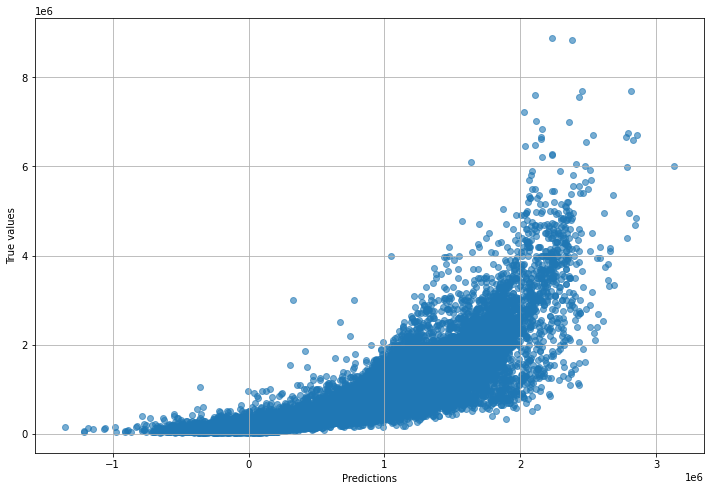

In [37]:
plot_prediction(predictions, y_test)

### 3.3. RandomForestRegressor

In [53]:
# param_grid = {'n_estimators': [100],
#              'max_depth': [10],
#              'min_samples_leaf': [10]}
# grid = GridSearchCV(RandomForestRegressor(n_jobs=-1), param_grid=param_grid, cv=4)

In [25]:
%%time
rfr = RandomForestRegressor(n_estimators=1000, max_depth=5, n_jobs=-1)
rfr.fit(X_train, y_train)

CPU times: user 9h 52min 8s, sys: 1min 27s, total: 9h 53min 36s
Wall time: 53min 15s


In [27]:
predictions = rfr.predict(X_test)
print("Mean Absolute Error : {:.2f}".format(mean_absolute_error(predictions, y_test)))

Mean Absolute Error : 145616.18


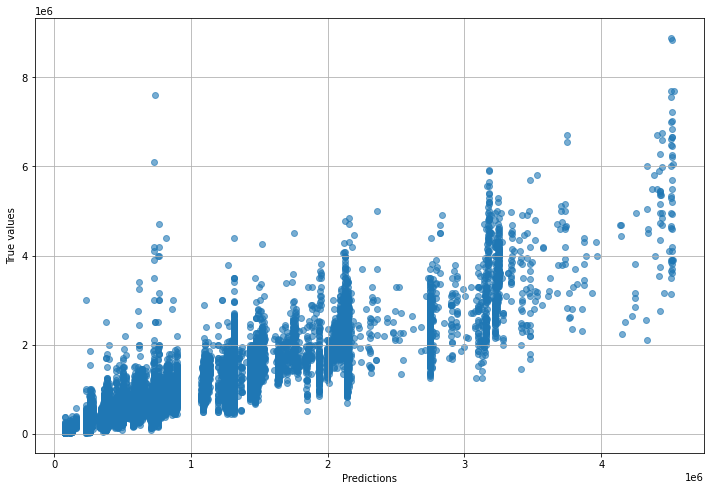

In [28]:
plot_prediction(predictions, y_test)

### 3.4  Boosting models
### 3.4.1 XGBoost

In [46]:
%%time
xgb_model = XGBRegressor(n_estimators=1000)
xgb_model.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)

XGBoostError: sklearn needs to be installed in order to use this module

In [38]:
predictions = xgb_model.predict(X_test)
print("Mean Absolute Error : {:.2f}".format(mean_absolute_error(predictions, y_test)))

NameError: name 'xgb_model' is not defined

In [ ]:
plot_prediction(predictions, y_test)

### 3.4.2 LightGBM

In [38]:
%%time
lgbm_model = LGBMRegressor(n_estimators=1000)
lgbm_model.fit(X_train.values, y_train)

CPU times: user 37.6 s, sys: 0 ns, total: 37.6 s
Wall time: 3.28 s


In [39]:
predictions = lgbm_model.predict(X_test)
print("Mean Absolute Error : {:.2f}".format(mean_absolute_error(predictions, y_test)))

Mean Absolute Error : 62900.56


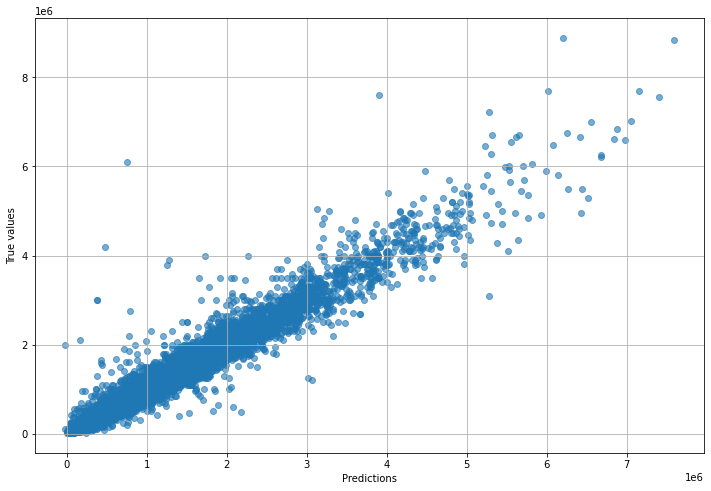

In [40]:
plot_prediction(predictions, y_test)

In [46]:
model = LGBMRegressor(
        learning_rate= 0.01,
        subsample=0.3,
        feature_fraction=0.5,
        num_iterations = 5000,
        max_bin=350,
        num_leaves= 300,
        lambda_l2=0.003,
        max_depth=200,
        min_data_in_leaf= 80,
        force_row_wise= True,)
        #objective='tweedie')

In [47]:
%%time
model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_valid,y_valid)],
             eval_metric='rmse',  verbose=100, early_stopping_rounds=20)

/home/mrmopoz/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
[100]	training's rmse: 285280	training's l2: 8.13848e+10	valid_1's rmse: 287945	valid_1's l2: 8.29122e+10
[200]	training's rmse: 168543	training's l2: 2.84067e+10	valid_1's rmse: 168888	valid_1's l2: 2.85231e+10
[300]	training's rmse: 133271	training's l2: 1.77612e+10	valid_1's rmse: 133619	valid_1's l2: 1.78541e+10
[400]	training's rmse: 121012	training's l2: 1.46438e+10	valid_1's rmse: 122668	valid_1's l2: 1.50475e+10
[500]	training's rmse: 114955	training's l2: 1.32146e+10	valid_1's rmse: 118260	valid_1's l2: 1.39855e+10
[600]	training's rmse: 111218	training's l2: 1.23694e+10	valid_1's rmse: 116171	valid_1's l2: 1.34957e+10
[700]	training's rmse: 108412	training's l2: 1.17533e+10	valid_1's rmse: 114979	valid_1's l2: 1.32203e+10
[800]	training's rmse: 106096	training's l2: 1.12563e+10	valid_1's rmse: 114144	valid_1's l2: 1.30288e+10
[900]	training's rmse: 104119	training's l2: 1.08409e+10	valid_1's rmse: 113660	valid_1's l

LGBMRegressor(feature_fraction=0.5, force_row_wise=True, lambda_l2=0.003,
              learning_rate=0.01, max_bin=350, max_depth=200,
              min_data_in_leaf=80, num_iterations=5000, num_leaves=300,
              subsample=0.3)

In [52]:
predictions = model.predict(X_test)
print("Mean Absolute Error : {:.2f}".format(mean_absolute_error(predictions, y_test)))

Mean Absolute Error : 61291.77


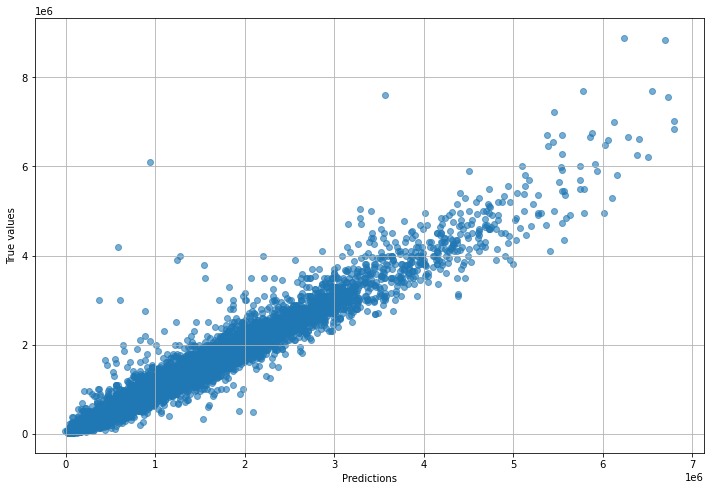

In [53]:
plot_prediction(predictions, y_test)

### 3.4.3 Catboost

In [49]:
%%time
cat_boost = CatBoostRegressor(n_estimators=1000, learning_rate=0.01)
cat_boost.fit(X_train.values, y_train)

0:	learn: 914100.2365557	total: 99.3ms	remaining: 1m 39s
1:	learn: 906032.7786638	total: 112ms	remaining: 55.9s
2:	learn: 898127.0040653	total: 123ms	remaining: 41s
3:	learn: 890223.9411633	total: 133ms	remaining: 33.1s
4:	learn: 882379.5564098	total: 143ms	remaining: 28.5s
5:	learn: 874695.9435254	total: 152ms	remaining: 25.2s
6:	learn: 867006.6915187	total: 163ms	remaining: 23.1s
7:	learn: 859462.1040097	total: 174ms	remaining: 21.5s
8:	learn: 851963.7739458	total: 183ms	remaining: 20.1s
9:	learn: 844537.4609269	total: 192ms	remaining: 19.1s
10:	learn: 837112.2505711	total: 202ms	remaining: 18.1s
11:	learn: 829843.8024236	total: 212ms	remaining: 17.5s
12:	learn: 822593.7691445	total: 223ms	remaining: 16.9s
13:	learn: 815459.9691386	total: 232ms	remaining: 16.3s
14:	learn: 808350.6183748	total: 242ms	remaining: 15.9s
15:	learn: 801510.8552640	total: 251ms	remaining: 15.4s
16:	learn: 794594.2015987	total: 263ms	remaining: 15.2s
17:	learn: 787821.5913959	total: 272ms	remaining: 14.8s
18

156:	learn: 299654.3293389	total: 1.74s	remaining: 9.34s
157:	learn: 298213.2004978	total: 1.75s	remaining: 9.34s
158:	learn: 296767.8304751	total: 1.76s	remaining: 9.33s
159:	learn: 295361.2130541	total: 1.77s	remaining: 9.31s
160:	learn: 293954.8540032	total: 1.78s	remaining: 9.3s
161:	learn: 292578.4980752	total: 1.79s	remaining: 9.28s
162:	learn: 291196.7483838	total: 1.8s	remaining: 9.27s
163:	learn: 289843.8139350	total: 1.81s	remaining: 9.25s
164:	learn: 288531.9781556	total: 1.82s	remaining: 9.23s
165:	learn: 287220.0863673	total: 1.83s	remaining: 9.22s
166:	learn: 285948.3691729	total: 1.85s	remaining: 9.21s
167:	learn: 284653.7497564	total: 1.86s	remaining: 9.19s
168:	learn: 283366.8796592	total: 1.87s	remaining: 9.19s
169:	learn: 282126.2397511	total: 1.88s	remaining: 9.17s
170:	learn: 280881.0868328	total: 1.89s	remaining: 9.15s
171:	learn: 279584.4278608	total: 1.9s	remaining: 9.13s
172:	learn: 278391.9170332	total: 1.91s	remaining: 9.11s
173:	learn: 277159.1375452	total: 

318:	learn: 193149.4565208	total: 3.4s	remaining: 7.26s
319:	learn: 192927.6189575	total: 3.41s	remaining: 7.25s
320:	learn: 192674.9353626	total: 3.42s	remaining: 7.24s
321:	learn: 192426.7641644	total: 3.43s	remaining: 7.23s
322:	learn: 192168.0803948	total: 3.44s	remaining: 7.21s
323:	learn: 191871.9708353	total: 3.45s	remaining: 7.21s
324:	learn: 191596.5778823	total: 3.46s	remaining: 7.19s
325:	learn: 191375.8419829	total: 3.47s	remaining: 7.18s
326:	learn: 191154.9821173	total: 3.48s	remaining: 7.17s
327:	learn: 190903.3820336	total: 3.49s	remaining: 7.16s
328:	learn: 190706.6051643	total: 3.5s	remaining: 7.14s
329:	learn: 190496.3892400	total: 3.51s	remaining: 7.13s
330:	learn: 190287.8041462	total: 3.52s	remaining: 7.11s
331:	learn: 190095.1516044	total: 3.53s	remaining: 7.1s
332:	learn: 189913.2133261	total: 3.54s	remaining: 7.09s
333:	learn: 189733.4678751	total: 3.55s	remaining: 7.07s
334:	learn: 189526.4156321	total: 3.56s	remaining: 7.06s
335:	learn: 189345.9170632	total: 

476:	learn: 171034.8522588	total: 5.07s	remaining: 5.55s
477:	learn: 170974.5940572	total: 5.08s	remaining: 5.54s
478:	learn: 170892.4814361	total: 5.09s	remaining: 5.53s
479:	learn: 170766.2744315	total: 5.1s	remaining: 5.52s
480:	learn: 170702.7710317	total: 5.11s	remaining: 5.51s
481:	learn: 170652.0345778	total: 5.12s	remaining: 5.5s
482:	learn: 170491.2161395	total: 5.13s	remaining: 5.49s
483:	learn: 170439.5776395	total: 5.14s	remaining: 5.48s
484:	learn: 170323.9506585	total: 5.15s	remaining: 5.47s
485:	learn: 170263.2351555	total: 5.16s	remaining: 5.46s
486:	learn: 170210.2471420	total: 5.17s	remaining: 5.45s
487:	learn: 170166.0695457	total: 5.18s	remaining: 5.44s
488:	learn: 170045.0366395	total: 5.19s	remaining: 5.43s
489:	learn: 169896.3691395	total: 5.2s	remaining: 5.42s
490:	learn: 169858.3615948	total: 5.21s	remaining: 5.4s
491:	learn: 169771.4007524	total: 5.22s	remaining: 5.39s
492:	learn: 169710.2589393	total: 5.24s	remaining: 5.38s
493:	learn: 169537.1704730	total: 5

627:	learn: 160685.6449518	total: 6.71s	remaining: 3.98s
628:	learn: 160544.8526403	total: 6.73s	remaining: 3.97s
629:	learn: 160511.3402693	total: 6.74s	remaining: 3.96s
630:	learn: 160464.2243494	total: 6.75s	remaining: 3.95s
631:	learn: 160415.4975427	total: 6.76s	remaining: 3.94s
632:	learn: 160376.9912596	total: 6.77s	remaining: 3.93s
633:	learn: 160343.6240429	total: 6.78s	remaining: 3.92s
634:	learn: 160321.1943602	total: 6.79s	remaining: 3.9s
635:	learn: 160286.8229340	total: 6.8s	remaining: 3.89s
636:	learn: 160223.3910565	total: 6.81s	remaining: 3.88s
637:	learn: 160162.5343842	total: 6.82s	remaining: 3.87s
638:	learn: 160135.1609672	total: 6.83s	remaining: 3.86s
639:	learn: 160070.5457357	total: 6.84s	remaining: 3.85s
640:	learn: 160033.5978846	total: 6.85s	remaining: 3.83s
641:	learn: 160003.3595660	total: 6.86s	remaining: 3.82s
642:	learn: 159947.2759693	total: 6.86s	remaining: 3.81s
643:	learn: 159916.7930256	total: 6.87s	remaining: 3.8s
644:	learn: 159870.0700631	total: 

782:	learn: 153668.9726581	total: 8.34s	remaining: 2.31s
783:	learn: 153584.1211531	total: 8.36s	remaining: 2.3s
784:	learn: 153552.1641757	total: 8.37s	remaining: 2.29s
785:	learn: 153526.1112006	total: 8.38s	remaining: 2.28s
786:	learn: 153497.2467385	total: 8.39s	remaining: 2.27s
787:	learn: 153469.1448688	total: 8.4s	remaining: 2.26s
788:	learn: 153444.1531377	total: 8.41s	remaining: 2.25s
789:	learn: 153410.8078398	total: 8.42s	remaining: 2.24s
790:	learn: 153373.3089854	total: 8.43s	remaining: 2.23s
791:	learn: 153278.3422919	total: 8.44s	remaining: 2.22s
792:	learn: 153244.5746169	total: 8.45s	remaining: 2.21s
793:	learn: 153214.2289739	total: 8.46s	remaining: 2.19s
794:	learn: 153168.2592459	total: 8.47s	remaining: 2.18s
795:	learn: 153140.2740031	total: 8.48s	remaining: 2.17s
796:	learn: 153104.9482294	total: 8.49s	remaining: 2.16s
797:	learn: 153069.7626989	total: 8.51s	remaining: 2.15s
798:	learn: 153050.5916248	total: 8.52s	remaining: 2.14s
799:	learn: 153020.7656030	total:

935:	learn: 148472.8380948	total: 9.99s	remaining: 683ms
936:	learn: 148456.9814909	total: 10s	remaining: 672ms
937:	learn: 148446.2336395	total: 10s	remaining: 662ms
938:	learn: 148416.0295913	total: 10s	remaining: 651ms
939:	learn: 148396.3361522	total: 10s	remaining: 640ms
940:	learn: 148338.4137183	total: 10s	remaining: 629ms
941:	learn: 148318.3362014	total: 10s	remaining: 619ms
942:	learn: 148302.8196824	total: 10.1s	remaining: 608ms
943:	learn: 148277.3729625	total: 10.1s	remaining: 597ms
944:	learn: 148261.9444644	total: 10.1s	remaining: 586ms
945:	learn: 148240.4863726	total: 10.1s	remaining: 576ms
946:	learn: 148205.6170890	total: 10.1s	remaining: 565ms
947:	learn: 148173.6939042	total: 10.1s	remaining: 554ms
948:	learn: 148130.0486848	total: 10.1s	remaining: 543ms
949:	learn: 148110.5941518	total: 10.1s	remaining: 533ms
950:	learn: 148093.9196315	total: 10.1s	remaining: 522ms
951:	learn: 148061.3264962	total: 10.1s	remaining: 511ms
952:	learn: 148041.9605416	total: 10.1s	rem

In [50]:
predictions = cat_boost.predict(X_test.values)
print("Mean Absolute Error : {:.2f}".format(mean_absolute_error(predictions, y_test)))

Mean Absolute Error : 84290.00


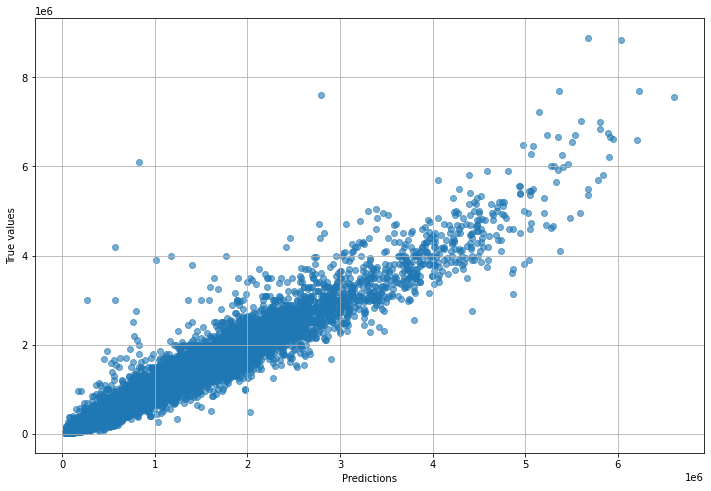

In [51]:
plot_prediction(predictions, y_test)

## TODO:

1. Generate new features
2. Look at  observations where models error, find features that determine errors
3. look at oabservations where all models error, find features that determine errors
4. Model composition/stacking